In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math

## Question

Is it possible to quench amorphous silicon at a rate of 100 K/ps, or is this limited by the thermal conductivity of the material (ie, no matter how good your contact, there is an inherent limitation from the rate at which heat can travel through bulk material).

Should be able to get an upper bound to the quench rate using simple heat diffusion equation (e.g. https://en.wikipedia.org/wiki/Heat_equation)


In this very, VERY simple classical model there is a slab of a-ZnO sandwiched between heat sinks.

The key parameters are the thermal diffusivity of a-ZnO, the material thickness, and the difference in temperature between a-ZnO and the heat sink. We assume this is 5000K, which may not be realistic for experimental studies (?). 

In [ ]:
# This is actually a 1D problem. the characteristic  time is L**2 / D

In [94]:
(100E-9)**2 / 1E-6

9.999999999999999e-09

This gives 10ns as the characteristic time over which heat diffuses through the system.

## Key model parameters

Couldn't find thermal diffusivity of a-ZnO from a quick scan of literature, but diffusivity for a-IZO is about 1E-6 (A quick scan of literature (https://doi.org/10.1116/1.2743644). 100nm for typical film thickness. These values can be adjusted to explore other diffusivites, material thickness or temperature difference. 

In [191]:
D = 1E-6
material_width = 100E-9  

In [192]:
T_contact = 0
T_material = 5000
T_target = 300

## Model Implementation - FTCS method

Solve the heat diffusion equation by calculating the laplacian in space using finite difference method, and evolving the system forward in time using Euler's method. Very basic, UG level numerical methods. From symmetry it can be reduced to a 1D problem.

In [193]:
def calculate_laplacian(temperature, Nx, h):

    laplacian = temperature * 0

    # assume that the temperature at the boundaries remains fixed
    for i in range(1,Nx-1):

            laplacian[i] = (temperature[i+1]+temperature[i-1]- 2*temperature[i]) / (h**2)
            
    return laplacian

def evolve_system(initial_temperature, T_max, D, Nx, h, t_step): 

    N_t_steps = int(np.ceil(T_max/t_step))
    temperature = initial_temperature
    
    for i in range(N_t_steps+1):
        
        laplacian_temperature = calculate_laplacian(temperature, Nx, h) 
        D_laplacian_temperature = D*laplacian_temperature
        temperature = temperature + (t_step*D_laplacian_temperature)
        
    return temperature

## Numerical parameters

To maintain numerical stability, the time step is determined from the diffusivity and the space step.

In [201]:
def determine_tstep(D,h):
    # We are using the FTCS scheme which is only stable if time_step < h*2 / 2*D
    return ((h**2)/(2*D))

In [202]:
Nx = 100
h = material_width / Nx
t_step = determine_tstep(D,h)

if t_step > 1E-13:
    t_step = 1E-13

## Initial conditions

In [203]:
initial_temperature = np.zeros(Nx)+T_material
initial_temperature[-1] = T_contact
initial_temperature[0] = T_contact

Text(0.5, 1.0, 'initial temperature')

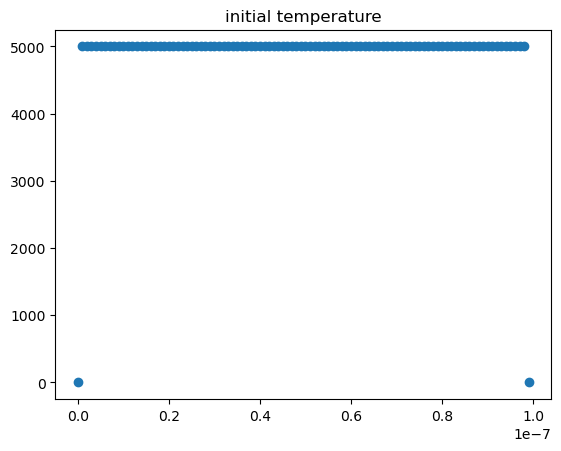

In [204]:
plt.scatter([h*i for i in range(Nx)],initial_temperature)
plt.title("initial temperature")

## Average temperature loss

the material will not cool at the same rate across the whole sample. The edges closest to the heat sink will cool fastest. To give a single rate across the whole material, we calculate the mean average change.

In [205]:
def calc_average_temp_lost(initial_temperature,current_temperature):
    return np.average(initial_temperature[1:-1] - current_temperature[1:-1])

## Evolve system

The maximum temperature is  5000.0
The mean average temperature drop from the initial temperature is  77.95894079183672


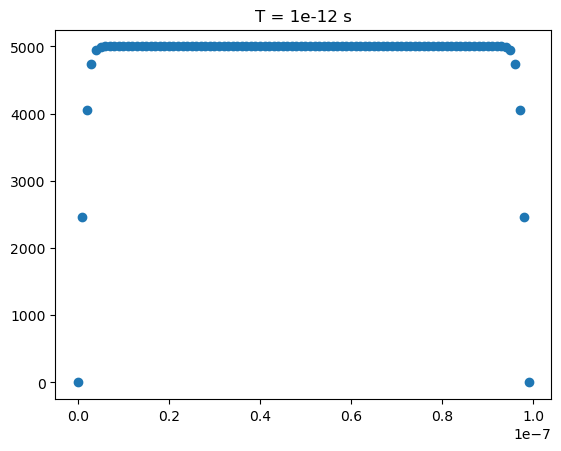

In [206]:
time=1E-12
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

The maximum temperature is  5000.0
The mean average temperature drop from the initial temperature is  121.7841667770306


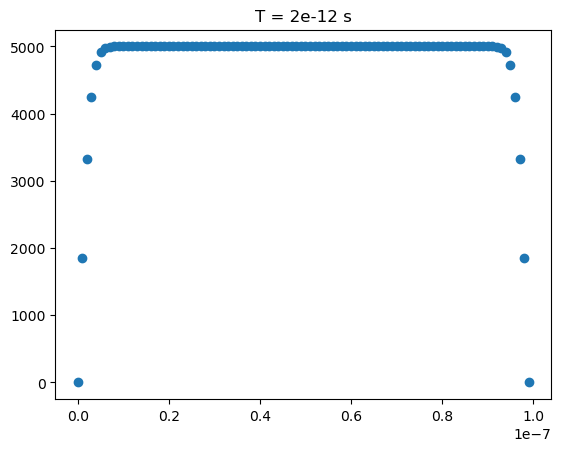

In [207]:
time=2E-12
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

**This suggests that 100nm film with diffusivity at 1E-6 has an initial heat-diffusion-limited average cooling rate of about 60K/ps.**

The maximum temperature is  2324.767881439422
The mean average temperature drop from the initial temperature is  3504.631229056738


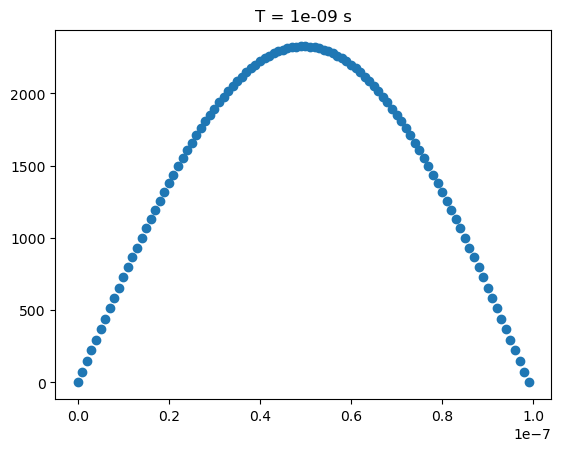

In [208]:
time=1E-9
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

The maximum temperature is  0.26949319451838916
The mean average temperature drop from the initial temperature is  4999.826677371451


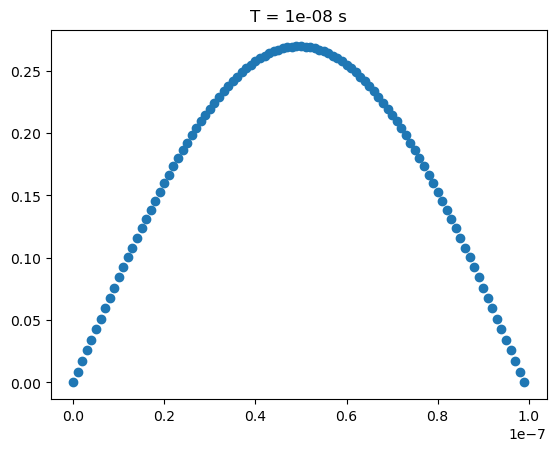

In [209]:
time=1E-8
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

**This is in line with the calculated characteristic time: it takes about 10ns to equilibriate**

Text(0, 0.5, 'average temperature decrease per ps (K/ps)')

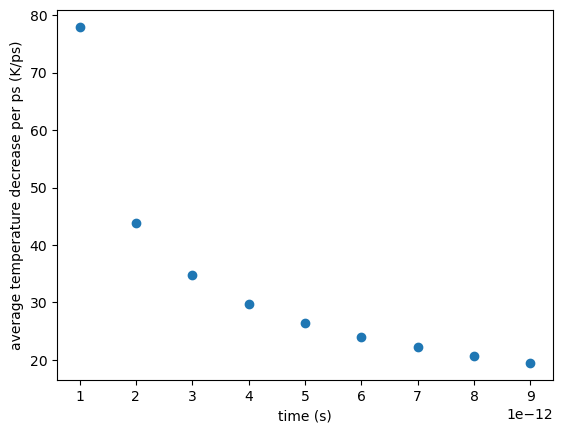

In [210]:
times = np.arange(1E-12,1E-11,1E-12)

average_temp_change = []
previous_temp = initial_temperature
for time in times:
    updated_temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
    average_temp_change.append(calc_average_temp_lost(previous_temp,updated_temp))
    previous_temp = updated_temp
    
plt.scatter(times,average_temp_change)
plt.xlabel("time (s)")
plt.ylabel("average temperature decrease per ps (K/ps)")



**As the system equilibriates the rate of cooling slows, as would be expected for a diffusion process**

The maximum temperature is  280.578286513957
The mean average temperature drop from the initial temperature is  4819.548073488267


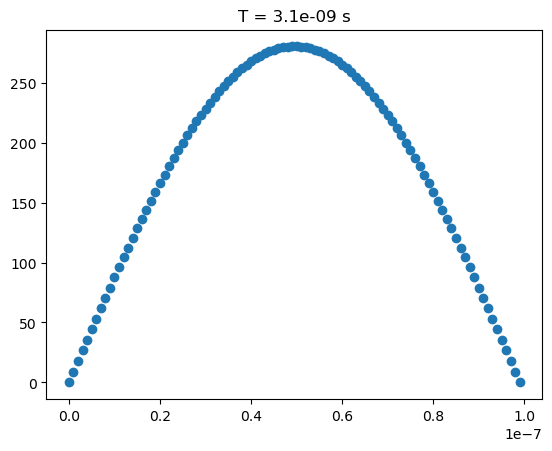

In [212]:
time=3.1E-9
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

It takes about 3ns for the temperature across the whole sample to drop to 300K or below. 

In [180]:
(4700/3E-9)*1E-12

1.5666666666666667

That is an average of 1.6K/ps.

## Varying thickness

1e-13
The maximum temperature is  5000.0
The mean average temperature drop from the initial temperature is  287.1295765769284


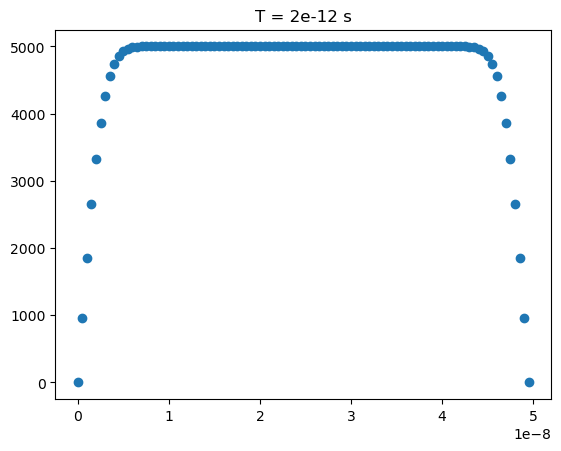

In [225]:
# material_width = 100E-9, average drop in temp 121 

material_width = 50E-9
Nx = 100
h = material_width / Nx

initial_temperature = np.zeros(Nx)+T_material
initial_temperature[-1] = T_contact
initial_temperature[0] = T_contact

t_step = determine_tstep(D,h)

if t_step > 1E-13:
    t_step = 1E-13
    
print(t_step)
    
time=2E-12
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

**So the thermal-diffusion limited quench rate is highly sensitive to the thickness, as you would imagine. At 50nm the initial thermal-diffusion limited quench rate is about 150 K/ps.**

## Varying Diffusivity

9.999999999999997e-14
The maximum temperature is  5000.0
The mean average temperature drop from the initial temperature is  335.12572852932675


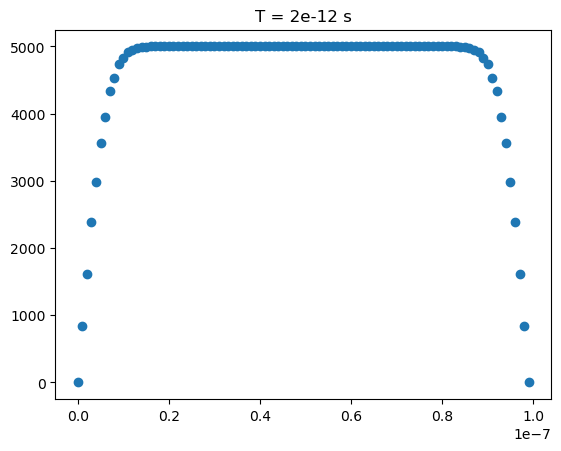

In [226]:
# material_width = 100E-9, D = 1E-9, average drop in temp 121 

D = 5E-6
material_width = 100E-9
Nx = 100
h = material_width / Nx

initial_temperature = np.zeros(Nx)+T_material
initial_temperature[-1] = T_contact
initial_temperature[0] = T_contact

t_step = determine_tstep(D,h)

if t_step > 1E-13:
    t_step = 1E-13
    
print(t_step)
    
time=2E-12
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

**So the thermal-diffusion limited quench rate is highly sensitive to the diffusivity, as you would imagine. At D=5E-6 the initial thermal-diffusion limited quench rate is about 160 K/ps.**


## Final notes

- More accurate values for D are needed for a-ZnO, to understand if there are material intrinsic reasons that a quench rate of 100K/ps is not possible.
- The model is very, very simple. For example, D will itself by dependent on temperature (as the thermal conducitivty is dependent on temperature), which is not accounted for here (but could be with relatively small adjustments...understanding the form of the T-dependence is the challenging part).
- Assuming that a-ZnO has a similar thermal diffusivity compared to a-IZO, the film needs to be below 100nm to achieve a quench rate of 100K/ps.

# Convergence tests

## Convergence with time step

The maximum temperature is  0.26964062235786906
The mean average temperature drop from the initial temperature is  4999.826582554287


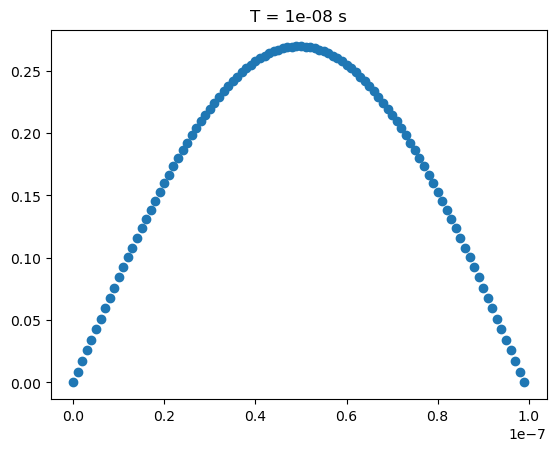

In [213]:
# Results for Nx = 100, t_step = 1E-13, time = 1E-8, delta T = 5000
# The maximum temperature is  0.26949319451838916
# The mean average temperature drop from the initial temperature is  4999.826677371451

t_step=1E-14
time=1E-8
temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
plt.scatter([h*i for i in range(Nx)],temp)
plt.title("T = {} s".format(time))
print("The maximum temperature is ",np.max(temp))
print("The mean average temperature drop from the initial temperature is ",calc_average_temp_lost(initial_temperature,temp))

## Convergence with Nx

In [219]:
# Results for Nx = 100, t_step = 1E-13, time = 1E-8, delta T = 5000
# The maximum temperature is  0.26949319451838916
# The mean average temperature drop from the initial temperature is  4999.826677371451

t_steps = []
temps_lost = []

for Nx in [100,110,120,130]:
    
    h = material_width / Nx
    t_step = determine_tstep(D,h)

    if t_step > 1E-13:
        t_step = 1E-13
        
    t_steps.append(t_step)

    initial_temperature = np.zeros(Nx)+T_material
    initial_temperature[-1] = T_contact
    initial_temperature[0] = T_contact

    time=1E-8
    temp = evolve_system(initial_temperature, time, D, Nx, h, t_step)
    temps_lost.append(calc_average_temp_lost(initial_temperature,temp))


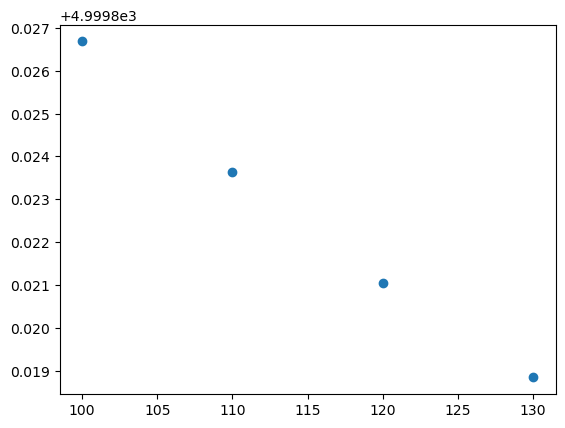

In [220]:
plt.scatter([100,110,120,130],temps_lost)